# Read Me Before starting
In this notebook, in silico perturbations will be performed for a number of genes. Performing systematic perturbation simulations requires knowledge of the operation of the celloracle software. Here are some caveats that we recommend you consider before starting a systematic simulation.

- If you are unfamiliar with CellOracle analysis, we do not recommend starting with this notebook. Please try the tutorial first.
- Before starting this notebook, please run an in silico perturbation simulation focused on a single gene. You will need to determine some hyperparameters. It is strongly recommended that you analyze only one gene at first to find the appropriate hyperparameters.
- The following code performs in silico TF perturbation on each gene and stores the results in the original data format. This could be very time consuming. Hyperparameter tuning should be done before this step. Otherwise, time will be wasted.
- We need to prepare `Oracle` object, `Links` object, and `Gradient` object beforehand. Please see our tutorial for more information on how to prepare them.
- This notebook uses the Paul et al. 2015 hematopoiesis dataset. Some parts, especially step 4.1, need to be tailored to your scRNA-seq data and the purpose of your analysis.
- The results of the systematic simulations performed in this notebook will be analyzed in the next notebook.

# 0. Import libraries
## 0.1. Import public libraries

In [1]:
import copy
import glob
import importlib
import time
import os
import shutil
import sys
from importlib import reload

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm.notebook import tqdm

#import time

## 0.2. Import our library

In [2]:
import celloracle as co
from celloracle.applications import Oracle_development_module
co.__version__

which: no R in (/opt/apps/labs/smlab/software/py_env/sc_env/bin:/ref/smlab/software/spack/opt/spack/linux-rocky8-x86_64/gcc-8.5.0/miniconda3-4.10.3-buvzc6uug3orkopkzbq3muf4f2o7c32y/condabin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ref/smlab/software/spack/bin)


'0.10.12'

## 0.3. Plotting parameter setting

In [3]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [5,5]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300

%matplotlib inline

# 1. Load data
## 1.1. Load oracle object

In [4]:
#oracle = co.data.load_tutorial_oracle_object()
oracle = co.load_hdf5("/scratch/smlab/ebutka/24_01_30_adi_with_pseudotime_monocle.celloracle.oracle")

## 1.2. Load inferred GRNs

In the previous notebook, we computed the GRN and saved as links object file. Now we will use this GRN to perform the simulation.


In [5]:
#links = co.data.load_tutorial_links_object()
links = co.load_hdf5("/scratch/smlab/ebutka/24_01_30_adi_with_pseudotime_monocle.celloracle.links")

## 1.3. Load gradient object

In [6]:
#gradient = co.load_hdf5("./Paul_etal.celloracle.gradient")
gradient = co.load_hdf5("/scratch/smlab/ebutka/24_01_30_adi_with_pseudotime_monocle.celloracle.gradient")

# Please make sure that the number of cells and dimensional reduction data is exact same between oracle object and gradient object
print(oracle.adata.shape, gradient.embedding.shape)

assert((oracle.adata.obsm[oracle.embedding_name] == gradient.embedding).all())

(19435, 3000) (19435, 2)


# 2. Process GRNs to make predictive models for simulation

## 2.1. Fit linear model again


In [7]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

  0%|          | 0/6 [00:00<?, ?it/s]

# 3. Check TF list that can be used for simulation.

Celloracle simulations use GRN models for the calculation. This means that We cannot simulate a TF if it is not present in the GRN models. Before starting a systematic simulation, please check which TFs are present in the GRN.

There are several possible reasons why the gene may not be on the list.
For example, celloracle's GRN inference method may not be able to detect a GRN edge for a gene if - 

- The gene is not in the gene expression marix after gene filtering. 
- Valiability level is too low.
- Gene expression level is too low or gene expression contains too many dropout.
- The gene does not have DNA-binding motifs.
 


In [8]:
# You can get the list of genes that have at least one regulatory connection in the inferred GRNs.
genes = oracle.active_regulatory_genes
genes

['Ahr',
 'Alx4',
 'Arid5a',
 'Arid5b',
 'Atf3',
 'Bach1',
 'Barx2',
 'Batf',
 'Batf3',
 'Bcl11a',
 'Bcl11b',
 'Bcl3',
 'Bhlhe22',
 'Bhlhe40',
 'Bhlhe41',
 'Brca1',
 'Cebpa',
 'Cebpb',
 'Chd2',
 'Creb3l3',
 'Creb5',
 'Ddit3',
 'E2f7',
 'E2f8',
 'Egr1',
 'Egr2',
 'Egr4',
 'En1',
 'Eno1',
 'Epas1',
 'Erf',
 'Esr1',
 'Ets1',
 'Ets2',
 'Etv1',
 'Etv3',
 'Etv5',
 'Ezh2',
 'Fos',
 'Fosb',
 'Fosl1',
 'Fosl2',
 'Foxd1',
 'Foxe1',
 'Foxg1',
 'Foxm1',
 'Foxp1',
 'Foxp2',
 'Foxs1',
 'Fubp1',
 'Gata2',
 'Gbx2',
 'Gfi1',
 'Gsc',
 'Hand2',
 'Hes1',
 'Heyl',
 'Hlf',
 'Hmga2',
 'Hmgn3',
 'Hoxa10',
 'Hoxa7',
 'Hoxa9',
 'Hoxb8',
 'Hoxb9',
 'Hoxc10',
 'Hoxc11',
 'Hoxc12',
 'Hoxc8',
 'Id1',
 'Id2',
 'Id3',
 'Ikzf4',
 'Irf1',
 'Irf4',
 'Irf7',
 'Irf8',
 'Irx1',
 'Irx3',
 'Irx5',
 'Jdp2',
 'Jun',
 'Junb',
 'Klf10',
 'Klf2',
 'Klf4',
 'Klf5',
 'Klf6',
 'Klf7',
 'Lbx1',
 'Lef1',
 'Lhx8',
 'Lmo2',
 'Maf',
 'Mafb',
 'Maff',
 'Mafk',
 'Mbd1',
 'Mecom',
 'Mef2c',
 'Meox1',
 'Meox2',
 'Msc',
 'Msx1',
 'Myb',
 'Mybl

In [9]:
len(genes)

165

# 4. Systematic simulation

We will perform simulations for all TFs listed above.
The results of the calculations are saved in hdf5 format in a local folder.
In this section, simulations are performed for each TF KO for the five conditions.

1. Simulate TF KO using whole cells.
2. Simulate TF KO focusing on Lineage_GM.
3. Simulate TF KO focusing on Lineage_ME.
4. Simulate TF KO focusing on Granurocyte cluster.
5. Simulate TF KO focusing on Monocyte cluster.


## 4.1 Make cell index list

For the simulation conditions #2~5, we will do simulation with a subset of cells. 
We need to get cell index list first. 

/opt/apps/labs/smlab/software/py_env/sc_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


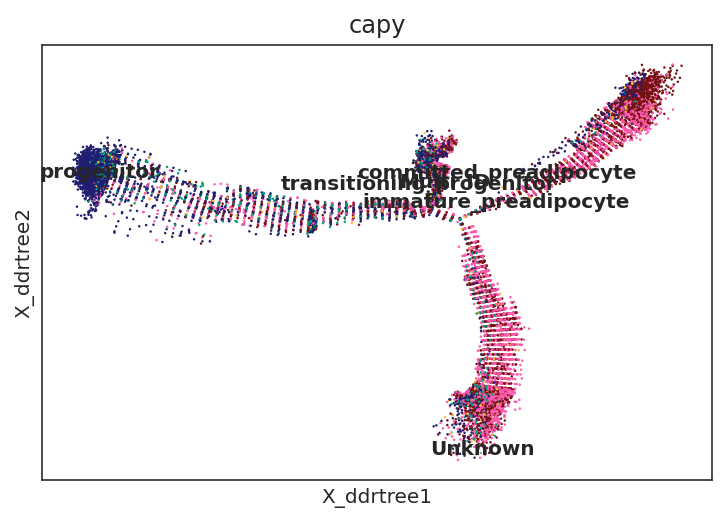

In [10]:
# Check data first
#sc.pl.draw_graph(oracle.adata, color="louvain_annot", legend_loc="on data")
sc.pl.embedding(oracle.adata, basis = "X_ddrtree", color = "capy", legend_loc = "on data")

In [11]:
# List of cluster name
#sorted(list(oracle.adata.obs["louvain_annot"].unique()))
sorted(list(oracle.adata.obs["capy"].unique()))

['Multi_ID',
 'Unknown',
 'committed_preadipocyte',
 'immature_preadipocyte',
 'progenitor',
 'transitioning_progenitor']

In [9]:
# Get cell_id

cell_idx_prog = np.where(oracle.adata.obs["capy"].isin([
    'progenitor']))[0]

cell_idx_transprog = np.where(oracle.adata.obs["capy"].isin([
    'transitioning_progenitor']))[0]

cell_idx_immpreadip = np.where(oracle.adata.obs["capy"].isin([
    'immature_preadipocyte']))[0]

cell_idx_commpreadip = np.where(oracle.adata.obs["capy"].isin([
    'committed_preadipocyte']))[0]


In [10]:
# Make dictionary to store the cell index list

index_dictionary = {"Whole_cells": None,
                    "Progenitors": cell_idx_prog,
                    "Transitioning_progenitors": cell_idx_transprog,
                    "Immature_preadipocytes": cell_idx_immpreadip,
                    "Committed_preadipocytes": cell_idx_commpreadip}

## 4.2. Make a custom function for the systematic KO workflow


We will do many simulations, and all results will be saved in a single hdf5 file.  `Oracle_development_module` is a custom class in the celloracle package to save and load simulation results.
Data will be stored hierarchically in one hdf5 file.

When save the results, please enter two parameters: gene and misc.
These two parameters are used as a key to save/load files into/from hdf5. 

> 1. gene (str): name of gene used in the perturb-simulation.
> 2. misc (str): name of the simulation, cell population or KO condition or etc. 

For example, you can save and load analysis resuts as follows.

 Save data into hdf file

```python
dev.set_hdf_path(path=file_path) 
dev.dump_hdf5(gene="Gata1", misc="Lineage_GMP")
```
 
 Load data from hdf file
```python
dev = Oracle_development_module()
dev.set_hdf_path(path=file_path) 
dev.load_hdf5(gene="Gata1", misc="Lineage_GMP")
 ```
 

**NOTE: It is very important here to adjust the simulation parameters to suit your analysis. Based on the results of the pilot analysis, please change the hyperparameters of the function below.**

In [11]:
# 0. Define parameters
n_propagation = 3
n_neighbors=200

file_path = "/scratch/smlab/ebutka/24_03_05_systematic_KO_simulation_results_p32_sbatch.celloracle.hdf5" # Please use .hdf5 for extension.


def pipeline(gene_for_KO):
     
    # 1. Simulate KO
    oracle.simulate_shift(perturb_condition={gene_for_KO: 0},
                                 ignore_warning=True,
                                 n_propagation=3)
    oracle.estimate_transition_prob(n_neighbors=n_neighbors, knn_random=True, sampled_fraction=1)
    oracle.calculate_embedding_shift(sigma_corr=0.05)

    # Do simulation for all conditions.
    for lineage_name, cell_idx in index_dictionary.items():
        
        dev = Oracle_development_module()
        # Load development flow
        dev.load_differentiation_reference_data(gradient_object=gradient)
        # Load simulation result
        dev.load_perturb_simulation_data(oracle_object=oracle, cell_idx_use=cell_idx, name=lineage_name)
        # Calculate inner product
        dev.calculate_inner_product()
        dev.calculate_digitized_ip(n_bins=10)
        
        # Save results in a hdf5 file.
        dev.set_hdf_path(path=file_path) 
        dev.dump_hdf5(gene=gene_for_KO, misc=lineage_name)
        

    
    

## 4.3. Test

Try function for one gene to check the function above is working.

In [21]:
%%time
# Test pipeline with Gata1 gene
pipeline(gene_for_KO="Sox9")

No hdf file found in the path. New hdf5 file was created.
CPU times: user 16min 29s, sys: 24.5 s, total: 16min 54s
Wall time: 5min 33s


## 4.4. Check result of test

**NOTE: Here, it is also important here to adjust the visualization scale parameters to suit your analysis.**

In [ ]:
# Make a new Oracle_developmennt_module object to read calculation result
dev_test = Oracle_development_module()

# Read result
dev_test.set_hdf_path(path=file_path)
dev_test.load_hdf5(gene="Sox9", misc="Whole_cells")

# Visualize result
dev_test.visualize_development_module_layout_0(s=5, scale_for_simulation=0.5, s_grid=50,
                                          scale_for_pseudotime=50, vm=0.04)

## 4.5. Run pipeline for all genes.



It might take long time.

In [ ]:
%%time
for gene in tqdm(genes):
    pipeline(gene_for_KO=gene)

  0%|          | 0/165 [00:00<?, ?it/s]

## 4.6. Make a custom function for the systematic OE workflow


We will do many simulations, and all results will be saved in a single hdf5 file.  `Oracle_development_module` is a custom class in the celloracle package to save and load simulation results.
Data will be stored hierarchically in one hdf5 file.

When save the results, please enter two parameters: gene and misc.
These two parameters are used as a key to save/load files into/from hdf5. 

> 1. gene (str): name of gene used in the perturb-simulation.
> 2. misc (str): name of the simulation, cell population or KO condition or etc. 

For example, you can save and load analysis resuts as follows.

 Save data into hdf file

```python
dev.set_hdf_path(path=file_path) 
dev.dump_hdf5(gene="Gata1", misc="Lineage_GMP")
```
 
 Load data from hdf file
```python
dev = Oracle_development_module()
dev.set_hdf_path(path=file_path) 
dev.load_hdf5(gene="Gata1", misc="Lineage_GMP")
 ```
 

**NOTE: It is very important here to adjust the simulation parameters to suit your analysis. Based on the results of the pilot analysis, please change the hyperparameters of the function below.**

In [11]:
# 0. Define parameters
n_propagation = 3
n_neighbors=200

file_path = "/scratch/smlab/ebutka/24_01_31_systematic_simulation_results_p32.celloracle.hdf5" # Please use .hdf5 for extension.


def pipeline(gene_for_OE):
     
    # 1. Simulate KO
    oracle.simulate_shift(perturb_condition={gene_for_OE: .95 * max(oracle.adata.X[:,np.where(oracle.adata.var.index == gene_for_OE)[0][0]].A)}, # emily changed here to simulate OE at 95% of max value
                                 ignore_warning=True,
                                 n_propagation=3)
    oracle.estimate_transition_prob(n_neighbors=n_neighbors, knn_random=True, sampled_fraction=1)
    oracle.calculate_embedding_shift(sigma_corr=0.05)

    # Do simulation for all conditions.
    for lineage_name, cell_idx in index_dictionary.items():
        
        dev = Oracle_development_module()
        # Load development flow
        dev.load_differentiation_reference_data(gradient_object=gradient)
        # Load simulation result
        dev.load_perturb_simulation_data(oracle_object=oracle, cell_idx_use=cell_idx, name=lineage_name)
        # Calculate inner product
        dev.calculate_inner_product()
        dev.calculate_digitized_ip(n_bins=10)
        
        # Save results in a hdf5 file.
        dev.set_hdf_path(path=file_path) 
        dev.dump_hdf5(gene=gene_for_OE, misc=lineage_name)
        

    
    

In [15]:
#os.remove(file_path)

## 4.7. Test

Try function for one gene to check the function above is working.

In [21]:
%%time
# Test pipeline with Gata1 gene
pipeline(gene_for_OE="Sox9")

No hdf file found in the path. New hdf5 file was created.
CPU times: user 16min 29s, sys: 24.5 s, total: 16min 54s
Wall time: 5min 33s


## 4.8. Check result of test

**NOTE: Here, it is also important here to adjust the visualization scale parameters to suit your analysis.**

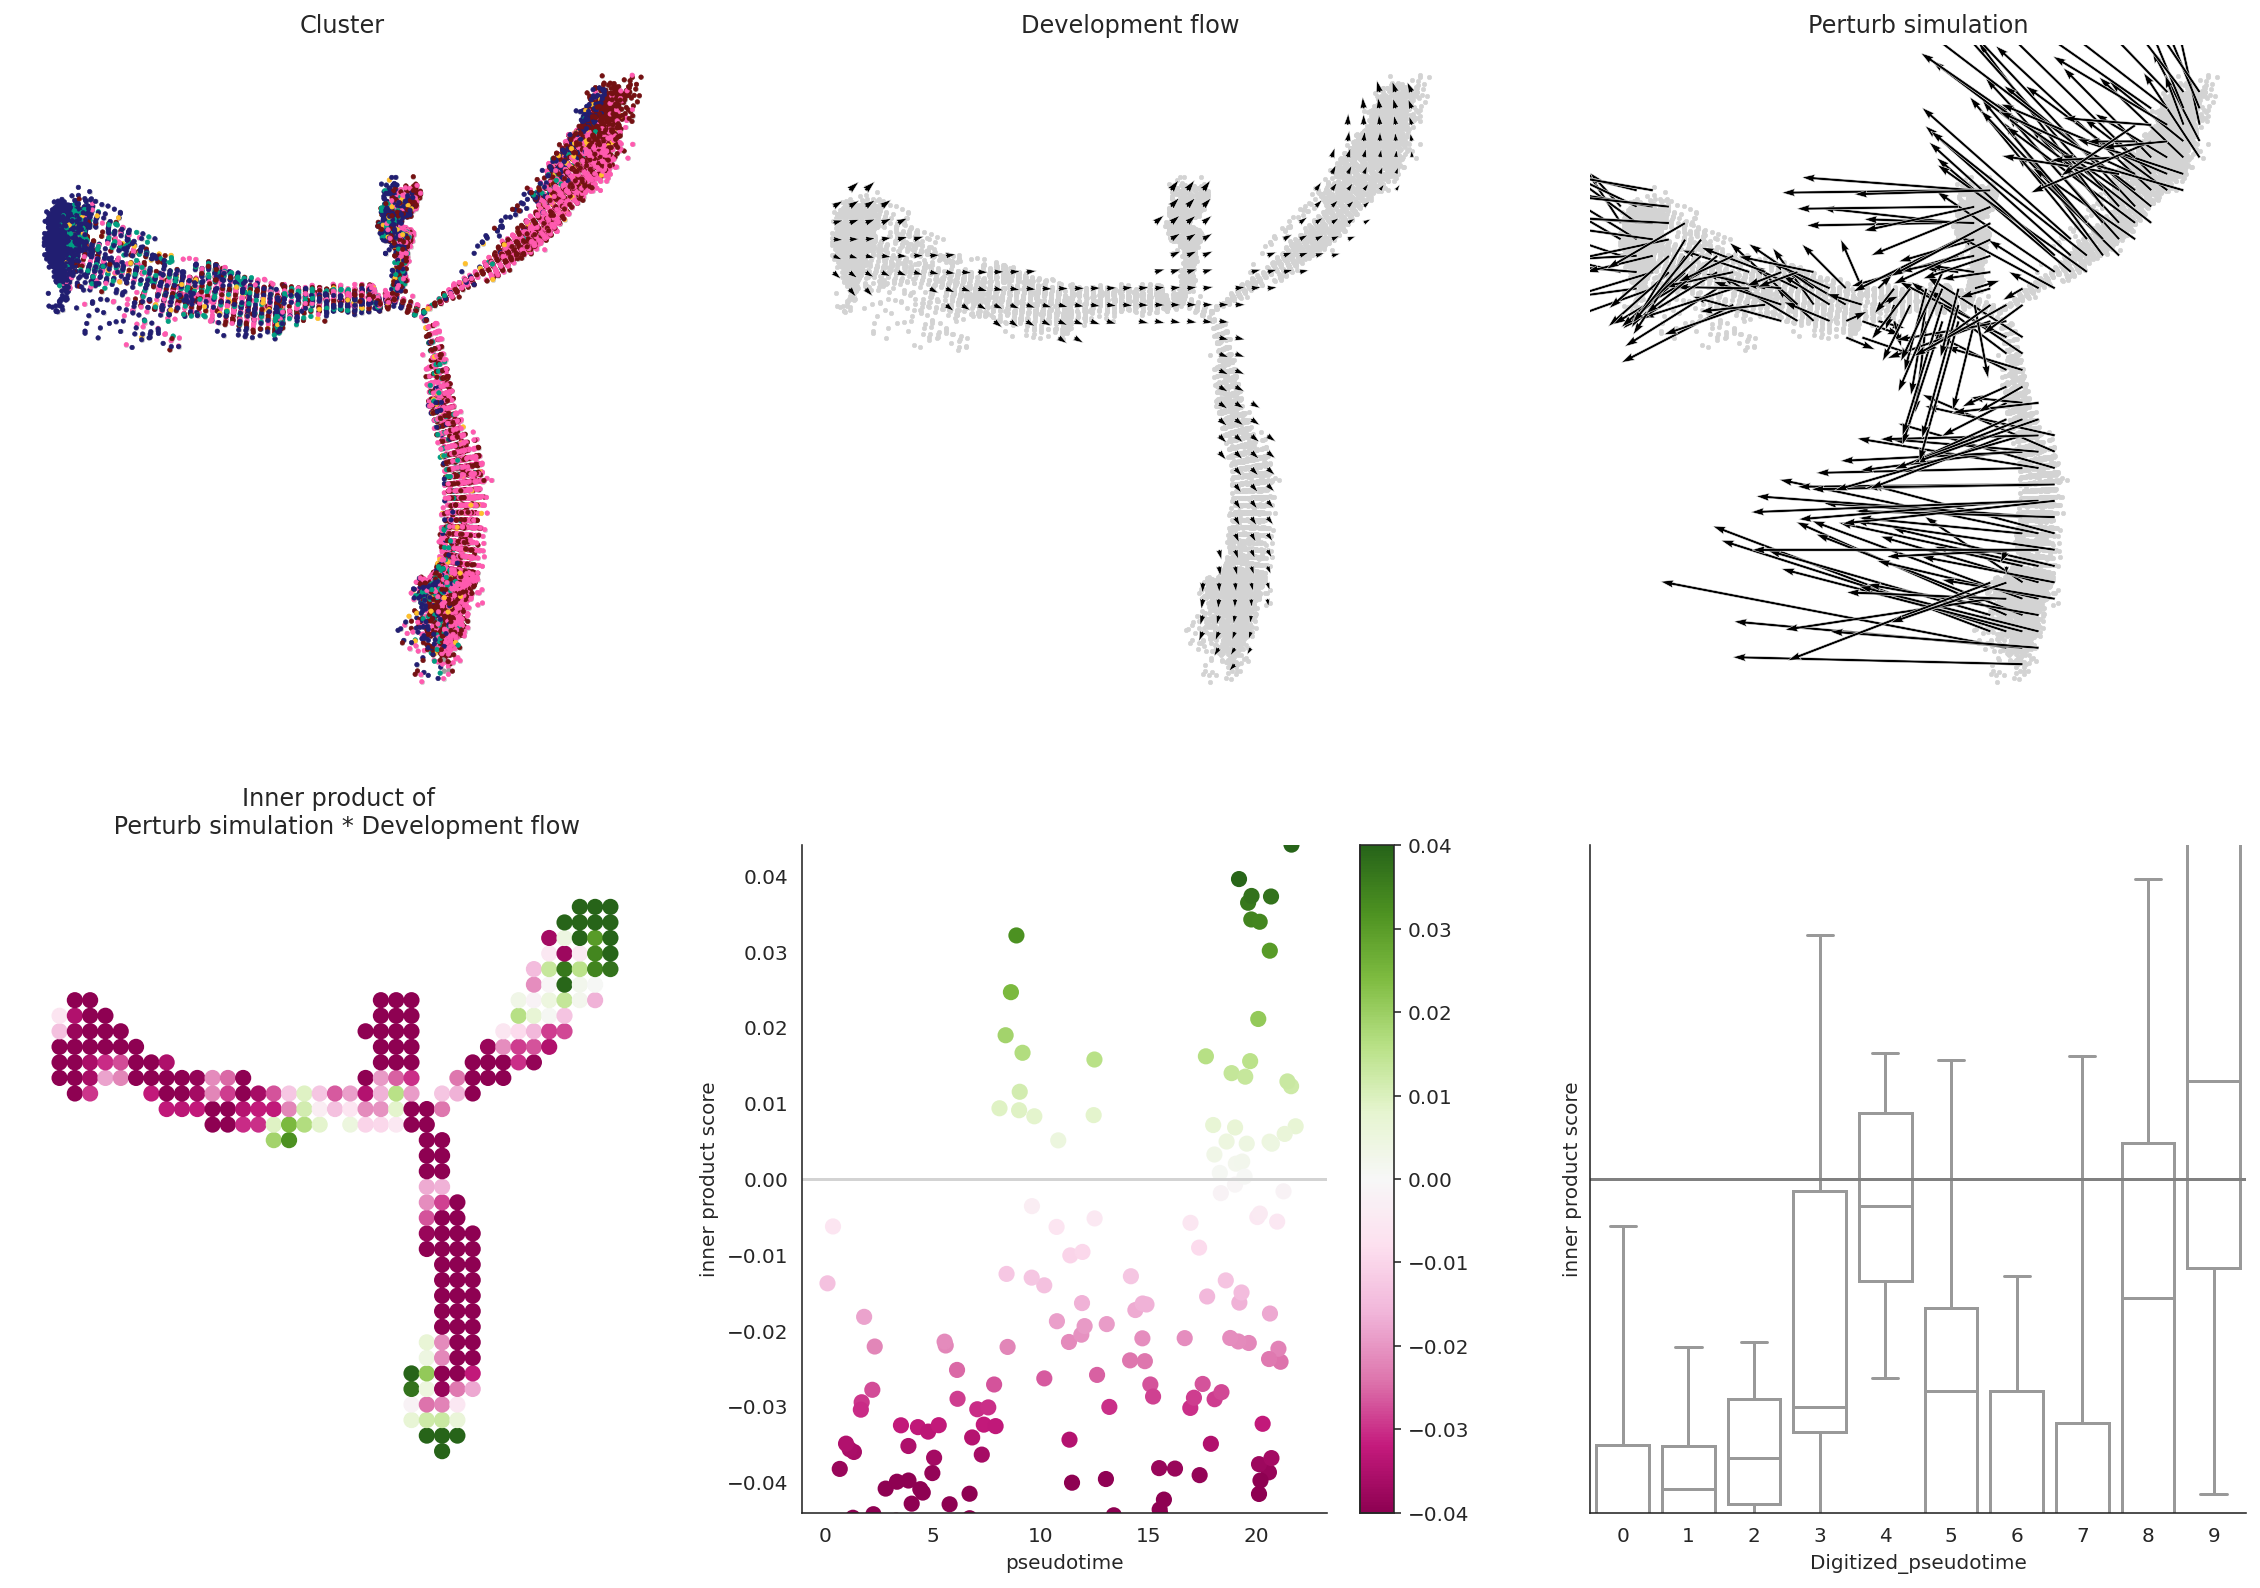

In [22]:
# Make a new Oracle_developmennt_module object to read calculation result
dev_test = Oracle_development_module()

# Read result
dev_test.set_hdf_path(path=file_path)
dev_test.load_hdf5(gene="Sox9", misc="Whole_cells")

# Visualize result
dev_test.visualize_development_module_layout_0(s=5, scale_for_simulation=0.5, s_grid=50,
                                          scale_for_pseudotime=50, vm=0.04)

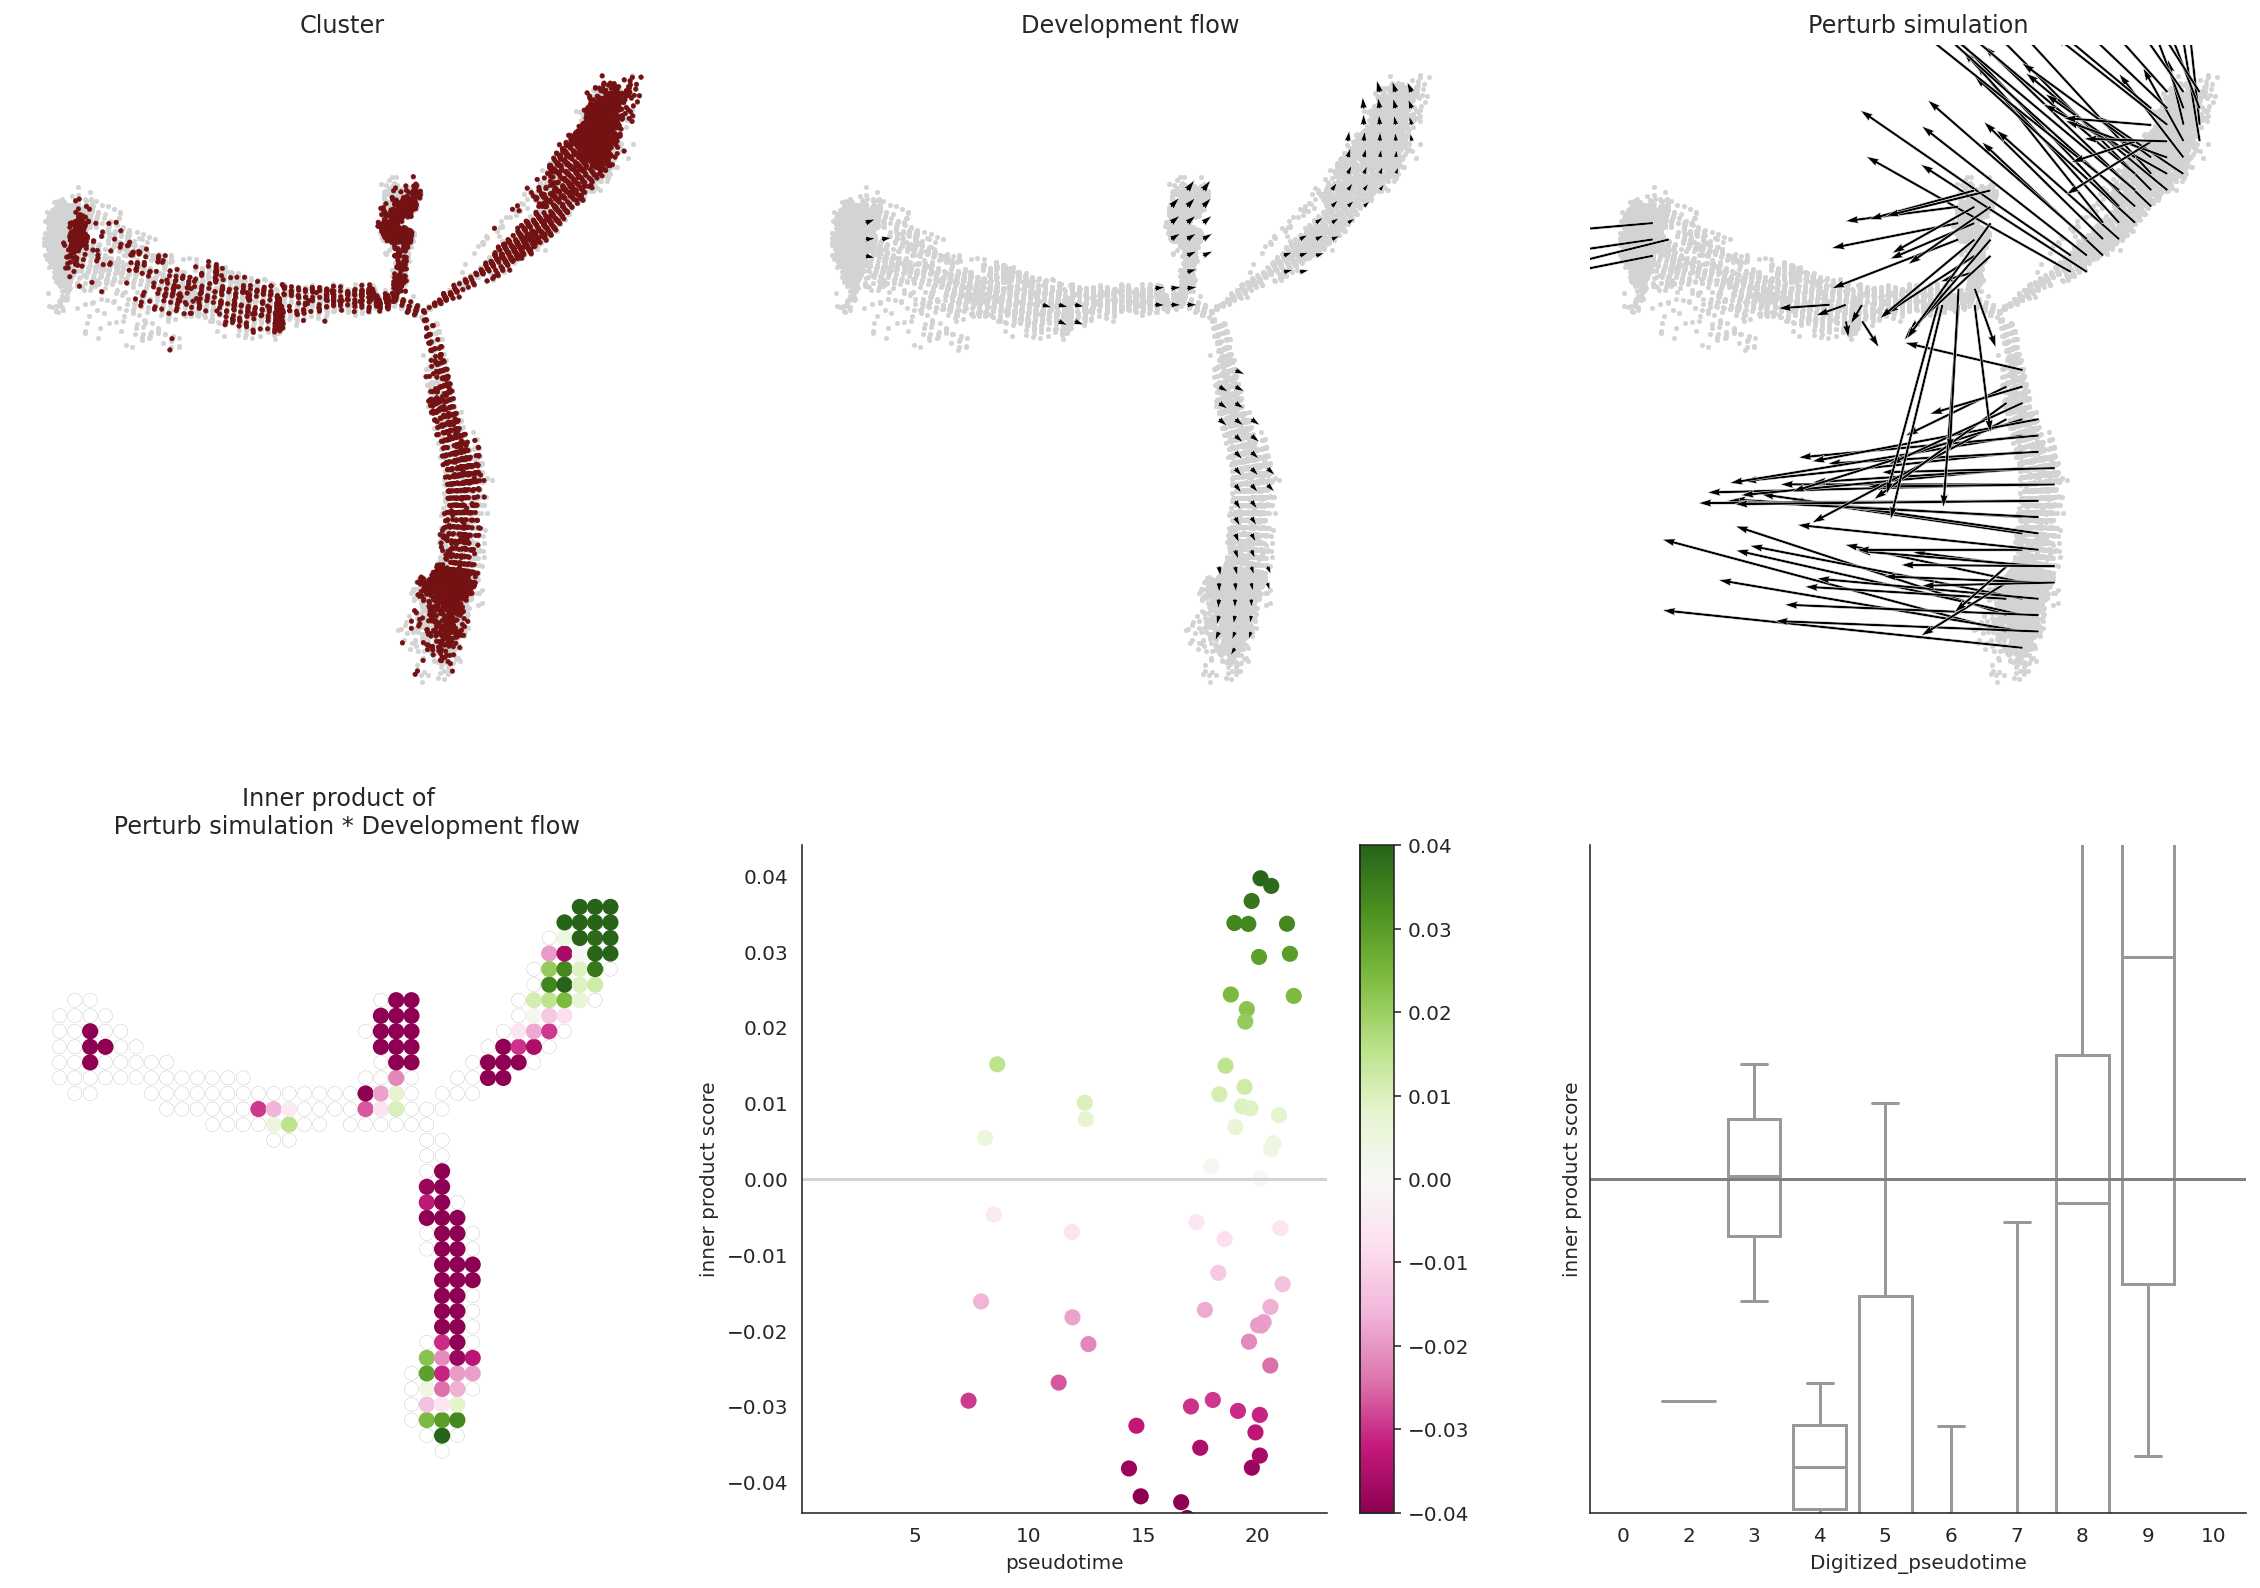

In [23]:
# Make a new Oracle_developmennt_module object to read calculation result
dev_test = Oracle_development_module()

# Read result
dev_test.set_hdf_path(path=file_path)
dev_test.load_hdf5(gene="Ahr", misc="Committed_preadipocytes")

# Visualize result
dev_test.visualize_development_module_layout_0(s=5, scale_for_simulation=0.5, s_grid=50,
                                          scale_for_pseudotime=50, vm=0.04)

## 4.9. Run pipeline for all genes.



It might take long time.

In [15]:
%%time
for gene in tqdm(genes):
    pipeline(gene_for_OE=gene)

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 1h 35min 39s, sys: 2min 53s, total: 1h 38min 32s
Wall time: 37min 14s


# 5. Visualizations

In [ ]:
# 4C, left
scale_dev = 40
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [ ]:
file_path = "/scratch/smlab/ebutka/24_03_05_systematic_KO_simulation_results_p32_sbatch.celloracle.hdf5" # Please use .hdf5 for extension.

In [ ]:
goi = "Sox9"
dev_test.load_hdf5(gene=goi, misc="Whole_cells")

In [ ]:
# 4C, middle
fig, ax = plt.subplots(1, 2,  figsize=[18, 7])

scale_simulation = 20
#goi = "Sox9"
# Show quiver plot
dev_test.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Perturbation simulation results: {goi} KO (expression set to 0)")

# Show quiver plot that was calculated with randomized GRN.
dev_test.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Perturbation simulation with randomized GRNs")

#plt.savefig("/scratch/smlab/ebutka/24_05_07_sox9_KO_perturbation_monocle_bw.pdf", dpi = 600)
plt.show()

In [ ]:
# 4C, right
fig, ax = plt.subplots(1, 2,  figsize=[18, 7])

scale_simulation = 20
#goi = "Pparg"
# Show quiver plot
dev_test.plot_inner_product_on_grid(s=50, ax=ax[0])
ax[0].set_title("Inner product of\nPerturb simulation * Development flow")

# Show quiver plot that was calculated with randomized GRN.
dev_test.plot_inner_product_on_pseudotime(ax=ax[1])
ax[1].set_title("Inner product score by Monocle pseudotime")

#plt.savefig("/scratch/smlab/ebutka/24_05_07_sox9_KO_perturbation_monocle_IP.pdf", dpi = 600)
plt.show()

# 6. Markov simulations

## About this section

It is written by Kenji Kamimoto. 20240225.

- This notebook explains how to perform Markov simulation with celloracle vector field data. This method is **NOT** a part of celloracle package.

- Please do not expect you can simulate cell density. The aim of this analysis is to help interpret your celloracle vector field. And it **does not aim for cell density simulation.**

- If you show Markov simulation results in paper or conference, please always show celloracle vector field together. Showing Markov simulation without celloracle vector field is misleading and dengerous.


- Prease do celloracle simulation and save results as hdf5 file using `Oracle_development_module` prior to the Markov simulation. We will load data from hdf5 to start Markov simulation.


## 6.1. Load data - KO

In [ ]:
dev = Oracle_development_module()

# Read result
#dev.set_hdf_path(path="24_01_31_systematic_simulation_results_p32.celloracle.hdf5") # OE
dev.set_hdf_path(path="24_03_05_systematic_KO_simulation_results_p32_sbatch.celloracle.hdf5")  # KO
dev.load_hdf5(gene="Sox9", misc="Whole_cells")

In [ ]:
# Check data

dev.plot_simulation_flow_on_grid(scale=50, s=50)
plt.axis("on")
plt.title("Perturbation vector")
plt.show()

dev.plot_inner_product_on_grid()
plt.title("Perturbation score")
plt.axis("on")
plt.show()


## 6.2 Preparation

Please adjust hyperparameters.
- `n_neighbors`: Number of neibors for the cell transition in single step.
- `epsilon_differentiation` & `epsilon_perturbation`: Large epsilon will lead to more random & smooth transition.
- `k`: Balance between perturbation effects and differentiation effects. Large k -> Higher weight on perturbation.

In [ ]:
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, #0.5
                      epsilon_perturbation=0.01,#0.01
                      k=.4)

## 6.3. Specify initial position

Here, we define starting population using coordinates.
Grid points < -0.5 were selected.

In [ ]:
# S4G
gridpoint_coordinates = simulator.embedding_positions.copy()
gridpoint_initial_density = np.zeros(gridpoint_coordinates.shape[0])
gridpoint_initial_density[gridpoint_coordinates[:, 0] < -0.5] = 1.0


fig = plt.figure()
plt.scatter(gridpoint_coordinates[:, 0], gridpoint_coordinates[:, 1],
            cmap="Greys", c=gridpoint_initial_density, s=30)
#plt.savefig(f"./figures/24_05_18_p32_OE_step_00.pdf")
plt.show()

## 6.4. Cell density transition simulation with differentiation transition probability.

!! Here we are **NOT** using perturbation vector yet.

In [ ]:
# S4H
# This examples calculating transition at n=1, 6, 15 steps.
for i in [1, 6, 15]:

    fig = plt.figure()
    _, gridpoint_density_simulated = diffuse(gridpoint_initial_density, # Initial cell density for each grid.
                    simulator.tr_differentiation, # Transition probability for differentiation.
                    n_steps=i, # Steps for simulation
                    )
    plt.scatter(gridpoint_coordinates[:, 0], gridpoint_coordinates[:, 1],
                cmap="Blues",
                vmax=0.009, # Max value for color visualization. Please adjust this number for each data.
                c=gridpoint_density_simulated, s=40)
    #plt.savefig(f"./figures/24_05_18_p32_pseudotime_gradient_{i:0=2}.pdf")
    plt.show()

## 6.5. Cell density transition simulation with differentiation transition probability and perturbation transition probability.


### 1. Preparation

Please adjust hyperparameters.
- `n_neighbors`: Number of neibors for the cell transition in single step.
- `epsilon_differentiation` & `epsilon_perturbation`: Large epsilon will lead to more random & smooth transition.
- `k`: Balance between perturbation effects and differentiation effects. Large k -> Higher weight on perturbation.

In [ ]:
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, 
                      epsilon_perturbation=0.01,
                      k=.4)

In [ ]:
# 4F, left
for i in [1, 6, 15]:
    gridpoint_density_simulated = cross_diffuse(
        embedding_positions=gridpoint_initial_density,# Initial cell density for each grid.
        tp_matrix0=simulator.tr_differentiation, # Transition probability for differentiation.
        tp_matrix1=simulator.tr_perturbation,# Transition probability for perturbation.
        n_steps=i, # Steps for simulation
        )


    plt.scatter(gridpoint_coordinates[:, 0], gridpoint_coordinates[:, 1],
                cmap="Blues",
                vmax=0.01,
                c=gridpoint_density_simulated, s=50)
    plt.axis("on")
    #plt.savefig("figures/case3_simulation.png", transparent=True)
    plt.savefig(f"./figures/24_05_21_p32_Sox9_KO_simulation_step_{i:0=2}.pdf")
    plt.show()

## 6.6. Cell density simulation with differentiation transition probability and random transition probability

In [ ]:
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow_rndm[~dev.mass_filter_reference, :],
    n_neighbors=30)
simulator.get_tp_diff(epsilon_differentiation=0.5, 
                      epsilon_perturbation=0.01,
                      k=.4)

In [ ]:
# S4I
for i in [1, 6, 15]:
    gridpoint_density_simulated = cross_diffuse(
        embedding_positions=gridpoint_initial_density,# Initial cell density for each grid.
        tp_matrix0=simulator.tr_differentiation, # Transition probability for differentiation.
        tp_matrix1=simulator.tr_perturbation,# Transition probability for perturbation.
        n_steps=i, # Steps for simulation
        )


    plt.scatter(gridpoint_coordinates[:, 0], gridpoint_coordinates[:, 1],
                cmap="Blues",
                vmax=0.01,
                c=gridpoint_density_simulated, s=50)
    plt.axis("on")
    #plt.savefig("figures/case3_simulation.png", transparent=True)
    plt.savefig(f"./figures/24_05_18_p32_simulation_random_step_{i:0=2}.pdf")
    plt.show()

## 6.7. Density simulations for knockout simulation perturbations of Id2, Zbtb7c, Nr4a2

In [ ]:
dev.load_hdf5(gene="Id2", misc="Whole_cells")
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, #0.5
                      epsilon_perturbation=0.01,#0.01
                      k=.4)
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, 
                      epsilon_perturbation=0.01,
                      k=.4)
# S4J
for i in [15]:
    gridpoint_density_simulated = cross_diffuse(
        embedding_positions=gridpoint_initial_density,# Initial cell density for each grid.
        tp_matrix0=simulator.tr_differentiation, # Transition probability for differentiation.
        tp_matrix1=simulator.tr_perturbation,# Transition probability for perturbation.
        n_steps=i, # Steps for simulation
        )


    plt.scatter(gridpoint_coordinates[:, 0], gridpoint_coordinates[:, 1],
                cmap="Blues",
                vmax=0.01,
                c=gridpoint_density_simulated, s=50)
    plt.axis("on")
    #plt.savefig("figures/case3_simulation.png", transparent=True)
    plt.savefig(f"./figures/24_05_21_p32_Id2_KO_simulation_step_{i:0=2}.pdf")
    plt.show()

In [ ]:
dev.load_hdf5(gene="Zbtb7c", misc="Whole_cells")
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, #0.5
                      epsilon_perturbation=0.01,#0.01
                      k=.4)
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, 
                      epsilon_perturbation=0.01,
                      k=.4)
# S4J
for i in [15]:
    gridpoint_density_simulated = cross_diffuse(
        embedding_positions=gridpoint_initial_density,# Initial cell density for each grid.
        tp_matrix0=simulator.tr_differentiation, # Transition probability for differentiation.
        tp_matrix1=simulator.tr_perturbation,# Transition probability for perturbation.
        n_steps=i, # Steps for simulation
        )


    plt.scatter(gridpoint_coordinates[:, 0], gridpoint_coordinates[:, 1],
                cmap="Blues",
                vmax=0.01,
                c=gridpoint_density_simulated, s=50)
    plt.axis("on")
    #plt.savefig("figures/case3_simulation.png", transparent=True)
    plt.savefig(f"./figures/24_05_21_p32_Zbtb7c_KO_simulation_step_{i:0=2}.pdf")
    plt.show()

In [ ]:
dev.load_hdf5(gene="Nr4a2", misc="Whole_cells")
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, #0.5
                      epsilon_perturbation=0.01,#0.01
                      k=.4)
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, 
                      epsilon_perturbation=0.01,
                      k=.4)
# S4J
for i in [15]:
    gridpoint_density_simulated = cross_diffuse(
        embedding_positions=gridpoint_initial_density,# Initial cell density for each grid.
        tp_matrix0=simulator.tr_differentiation, # Transition probability for differentiation.
        tp_matrix1=simulator.tr_perturbation,# Transition probability for perturbation.
        n_steps=i, # Steps for simulation
        )


    plt.scatter(gridpoint_coordinates[:, 0], gridpoint_coordinates[:, 1],
                cmap="Blues",
                vmax=0.01,
                c=gridpoint_density_simulated, s=50)
    plt.axis("on")
    #plt.savefig("figures/case3_simulation.png", transparent=True)
    plt.savefig(f"./figures/24_05_21_p32_Nr4a2_KO_simulation_step_{i:0=2}.pdf")
    plt.show()

## 6.8. Load data - OE

In [ ]:
dev = Oracle_development_module()

# Read result
dev.set_hdf_path(path="24_01_31_systematic_simulation_results_p32.celloracle.hdf5") # OE
dev.load_hdf5(gene="Sox9", misc="Whole_cells")

In [ ]:
# Check data

dev.plot_simulation_flow_on_grid(scale=50, s=50)
plt.axis("on")
plt.title("Perturbation vector")
plt.show()

dev.plot_inner_product_on_grid()
plt.title("Perturbation score")
plt.axis("on")
plt.show()


## 6.9. Preparation

Please adjust hyperparameters.
- `n_neighbors`: Number of neibors for the cell transition in single step.
- `epsilon_differentiation` & `epsilon_perturbation`: Large epsilon will lead to more random & smooth transition.
- `k`: Balance between perturbation effects and differentiation effects. Large k -> Higher weight on perturbation.

In [ ]:
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, #0.5
                      epsilon_perturbation=0.01,#0.01
                      k=.4)

## 6.10. Specify initial position

Here, we define starting population using coordinates.
Grid points < -0.5 were selected.

In [ ]:
# S4G
gridpoint_coordinates = simulator.embedding_positions.copy()
gridpoint_initial_density = np.zeros(gridpoint_coordinates.shape[0])
gridpoint_initial_density[gridpoint_coordinates[:, 0] < -0.5] = 1.0


fig = plt.figure()
plt.scatter(gridpoint_coordinates[:, 0], gridpoint_coordinates[:, 1],
            cmap="Greys", c=gridpoint_initial_density, s=30)
#plt.savefig(f"./figures/24_05_18_p32_OE_step_00.pdf")
plt.show()

## 6.11. Cell density transition simulation with differentiation transition probability and perturbation transition probability.


### 1. Preparation

Please adjust hyperparameters.
- `n_neighbors`: Number of neibors for the cell transition in single step.
- `epsilon_differentiation` & `epsilon_perturbation`: Large epsilon will lead to more random & smooth transition.
- `k`: Balance between perturbation effects and differentiation effects. Large k -> Higher weight on perturbation.

In [ ]:
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, 
                      epsilon_perturbation=0.01,
                      k=.4)

In [ ]:
# 4F, right
for i in [1, 6, 15]:
    gridpoint_density_simulated = cross_diffuse(
        embedding_positions=gridpoint_initial_density,# Initial cell density for each grid.
        tp_matrix0=simulator.tr_differentiation, # Transition probability for differentiation.
        tp_matrix1=simulator.tr_perturbation,# Transition probability for perturbation.
        n_steps=i, # Steps for simulation
        )


    plt.scatter(gridpoint_coordinates[:, 0], gridpoint_coordinates[:, 1],
                cmap="Blues",
                vmax=0.01,
                c=gridpoint_density_simulated, s=50)
    plt.axis("on")
    #plt.savefig("figures/case3_simulation.png", transparent=True)
    plt.savefig(f"./figures/24_05_21_p32_Sox9_OE_simulation_step_{i:0=2}.pdf")
    plt.show()

## 6.12. Density simulations for knockout simulation perturbations of Id2, Zbtb7c, Nr4a2

In [ ]:
dev.load_hdf5(gene="Id2", misc="Whole_cells")
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, #0.5
                      epsilon_perturbation=0.01,#0.01
                      k=.4)
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, 
                      epsilon_perturbation=0.01,
                      k=.4)
# S4J
for i in [15]:
    gridpoint_density_simulated = cross_diffuse(
        embedding_positions=gridpoint_initial_density,# Initial cell density for each grid.
        tp_matrix0=simulator.tr_differentiation, # Transition probability for differentiation.
        tp_matrix1=simulator.tr_perturbation,# Transition probability for perturbation.
        n_steps=i, # Steps for simulation
        )


    plt.scatter(gridpoint_coordinates[:, 0], gridpoint_coordinates[:, 1],
                cmap="Blues",
                vmax=0.01,
                c=gridpoint_density_simulated, s=50)
    plt.axis("on")
    #plt.savefig("figures/case3_simulation.png", transparent=True)
    plt.savefig(f"./figures/24_05_21_p32_Id2_OE_simulation_step_{i:0=2}.pdf")
    plt.show()

In [ ]:
dev.load_hdf5(gene="Zbtb7c", misc="Whole_cells")
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, #0.5
                      epsilon_perturbation=0.01,#0.01
                      k=.4)
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, 
                      epsilon_perturbation=0.01,
                      k=.4)
# S4J
for i in [15]:
    gridpoint_density_simulated = cross_diffuse(
        embedding_positions=gridpoint_initial_density,# Initial cell density for each grid.
        tp_matrix0=simulator.tr_differentiation, # Transition probability for differentiation.
        tp_matrix1=simulator.tr_perturbation,# Transition probability for perturbation.
        n_steps=i, # Steps for simulation
        )


    plt.scatter(gridpoint_coordinates[:, 0], gridpoint_coordinates[:, 1],
                cmap="Blues",
                vmax=0.01,
                c=gridpoint_density_simulated, s=50)
    plt.axis("on")
    #plt.savefig("figures/case3_simulation.png", transparent=True)
    plt.savefig(f"./figures/24_05_21_p32_Zbtb7c_OE_simulation_step_{i:0=2}.pdf")
    plt.show()

In [ ]:
dev.load_hdf5(gene="Nr4a2", misc="Whole_cells")
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, #0.5
                      epsilon_perturbation=0.01,#0.01
                      k=.4)
simulator = Diffusion_simulator(
    embedding_positions=dev.gridpoints_coordinates[~dev.mass_filter_reference],
    vector_differentiation=dev.ref_flow[~dev.mass_filter_reference, :],
    vector_perturbation=dev.flow[~dev.mass_filter_reference, :],
    n_neighbors=30)

simulator.get_tp_diff(epsilon_differentiation=0.5, 
                      epsilon_perturbation=0.01,
                      k=.4)
# S4J
for i in [15]:
    gridpoint_density_simulated = cross_diffuse(
        embedding_positions=gridpoint_initial_density,# Initial cell density for each grid.
        tp_matrix0=simulator.tr_differentiation, # Transition probability for differentiation.
        tp_matrix1=simulator.tr_perturbation,# Transition probability for perturbation.
        n_steps=i, # Steps for simulation
        )


    plt.scatter(gridpoint_coordinates[:, 0], gridpoint_coordinates[:, 1],
                cmap="Blues",
                vmax=0.01,
                c=gridpoint_density_simulated, s=50)
    plt.axis("on")
    #plt.savefig("figures/case3_simulation.png", transparent=True)
    plt.savefig(f"./figures/24_05_21_p32_Nr4a2_OE_simulation_step_{i:0=2}.pdf")
    plt.show()